In [1]:
# Modules used for data handling and manipulation
import numpy as np
import pandas as pd
import json

# Modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# Modules used for statistical inference
from statsmodels.tsa.stattools import adfuller

# Modules used for preprocessing
from sklearn.preprocessing import StandardScaler

# Modules used for time series forecasting
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modules used for model evaluation
from sklearn.metrics import mean_absolute_percentage_error
import evaluation

# Modules used for preprocessing
from datetime import datetime
import preprocess

# Module for suppressing warnings
import warnings 
warnings.filterwarnings('ignore')

# Consolidating the data

In [2]:
electricity = preprocess.preprocess_modelling(as_numpy=False, clustered=True)
temperature = preprocess.preprocess("temperature")
precipitation = preprocess.preprocess("precipitation")

In [3]:
electricity = electricity.drop(pd.to_datetime("2015-01-01"))

In [4]:
weather = temperature.merge(precipitation)

# The time-series (original)

In [5]:
size = [0, 0]
with open("clusters.json", "r") as f:
    clusters = json.load(fp = f)
    size[0] = len(clusters["0"])
    size[1] = len(clusters["1"])

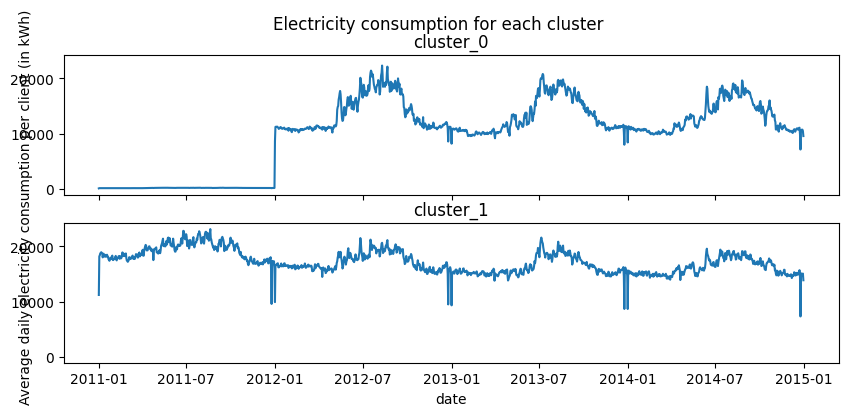

In [6]:
clusters = ["cluster_0", "cluster_1"]

fig, axs = plt.subplots(2, 1, figsize = (10, 4), 
                        sharex = True, sharey = True)

for i in range(0, len(clusters)):
    # Original values were in kW of 15 minutes - to convert to kWh, divide by 4
    axs[i].plot(electricity[clusters[i]]/(4 * size[i]))
    axs[i].set_title(clusters[i])

plt.xlabel("date")
fig.text(0.08, 0.5, 'Average daily electricity consumption per client (in kWh)', 
         va='center', rotation='vertical')
plt.suptitle("Electricity consumption for each cluster")
plt.show()

The time series for each cluster are not stationary but we can verify this with Augmented Dickey-Fuller test.

# Test for stationarity

In [7]:
test_res = adfuller(electricity["cluster_0"])

pprint.pprint(dict(zip(["test statistic", "p-value", 
            "used lags", "samples",
            "t-critical values",
            "information criterion"], test_res)))

{'information criterion': np.float64(41206.36180121677),
 'p-value': np.float64(0.3998314678325289),
 'samples': 1451,
 't-critical values': {'1%': np.float64(-3.4348647527922824),
                       '10%': np.float64(-2.567831568508802),
                       '5%': np.float64(-2.863533960720434)},
 'test statistic': np.float64(-1.761311504963052),
 'used lags': 9}


In [8]:
test_res = adfuller(electricity["cluster_1"])

pprint.pprint(dict(zip(["test statistic", "p-value", 
            "used lags", "samples",
            "t-critical values",
            "information criterion"], test_res)))

{'information criterion': np.float64(41099.21400777678),
 'p-value': np.float64(0.47652336646294224),
 'samples': 1439,
 't-critical values': {'1%': np.float64(-3.4349024693573584),
                       '10%': np.float64(-2.5678404322793846),
                       '5%': np.float64(-2.8635506057382325)},
 'test statistic': np.float64(-1.6127667977979123),
 'used lags': 21}


- In both cases, the p-value is greater than the alpha value (1%, 5%, and 10%). 
- Therefore, we fail to reject the null hypothesis which implies that there is non-stationarity in both the time series.

# Making the time series stationary

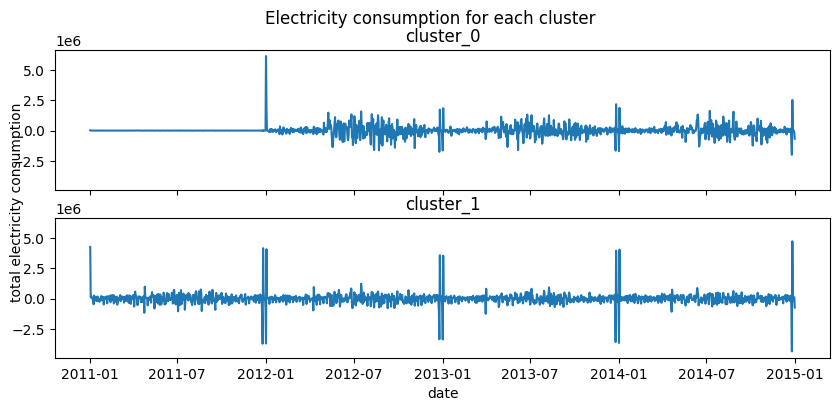

In [9]:
clusters = ["cluster_0", "cluster_1"]

fig, axs = plt.subplots(2, 1, figsize = (10, 4), 
                        sharex = True, sharey = True)

for i in range(0, len(clusters)):
    axs[i].plot(electricity[clusters[i]].diff())
    axs[i].set_title(clusters[i])

plt.xlabel("date")
fig.text(0.08, 0.5, 'total electricity consumption', 
         va='center', rotation='vertical')
plt.suptitle("Electricity consumption for each cluster")
plt.show()

These time-series appear to be relatively more stationary than the original time series but we can verify this using Augmented Dickey-Fuller test.

# Test for stationarity

In [10]:
test_res = adfuller(electricity["cluster_0"].diff()[1:])

pprint.pprint(dict(zip(["test statistic", "p-value", 
            "used lags", "samples",
            "t-critical values",
            "information criterion"], test_res)))

{'information criterion': np.float64(41179.88985328503),
 'p-value': np.float64(3.355333620180911e-28),
 'samples': 1451,
 't-critical values': {'1%': np.float64(-3.4348647527922824),
                       '10%': np.float64(-2.567831568508802),
                       '5%': np.float64(-2.863533960720434)},
 'test statistic': np.float64(-15.386321421705444),
 'used lags': 8}


In [11]:
test_res = adfuller(electricity["cluster_1"].diff()[1:])

pprint.pprint(dict(zip(["test statistic", "p-value", 
            "used lags", "samples",
            "t-critical values",
            "information criterion"], test_res)))

{'information criterion': np.float64(41072.15348509664),
 'p-value': np.float64(2.397634650127791e-20),
 'samples': 1439,
 't-critical values': {'1%': np.float64(-3.4349024693573584),
                       '10%': np.float64(-2.5678404322793846),
                       '5%': np.float64(-2.8635506057382325)},
 'test statistic': np.float64(-11.188792407931961),
 'used lags': 20}


- In both cases, the p-value is less than the alpha value (1%, 5%, and 10%). 
- Therefore, we can reject the null hypothesis which implies that the time series are now stationary.

# Modeling

In [12]:
import evaluation

In [13]:
cluster_0_norm = (electricity["cluster_0"]/(4 * size[0]))
cluster_1_norm = (electricity["cluster_1"]/(4 * size[1]))

In [14]:
temp = preprocess.preprocess("temperature")
precip = preprocess.preprocess("precipitation")

In [15]:
temp['date'] = pd.to_datetime(temp['date'])
precip['date'] = pd.to_datetime(precip['date'])

## Facebook Prophet

In [16]:
from prophet import Prophet

### Cluster 0

In [17]:
# For cluster 0, only consider readings after 2012
cluster_0_norm_reduced = cluster_0_norm.loc[datetime.strptime('2012-01-01', '%Y-%m-%d').date():]

In [18]:
# Reset index, rename columns
cluster_0_norm_final = cluster_0_norm_reduced.reset_index().rename(columns={"date": "ds", "cluster_0": "y"})
cluster_0_norm_final['ds'] = pd.to_datetime(cluster_0_norm_final['ds'])

In [19]:
cluster_0_norm_merged = cluster_0_norm_final.merge(temp, left_on='ds', right_on='date').merge(precip, left_on='ds', right_on='date')

In [20]:
cluster_0_train = cluster_0_norm_merged.iloc[0:731,:]
cluster_0_test = cluster_0_norm_merged.iloc[731:,:]

In [21]:
fb_prophet = Prophet()
fb_prophet.add_regressor('tmin')
fb_prophet.add_regressor('tmax')
fb_prophet.add_regressor('precip')
fb_prophet.fit(cluster_0_train)

18:36:05 - cmdstanpy - INFO - Chain [1] start processing
18:36:05 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
forecast = fb_prophet.predict(cluster_0_norm_merged)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,13617.857962,10154.093207,11818.618697,13617.857962,13617.857962,-2638.576663,-2638.576663,-2638.576663,-1036.188432,...,-171.167834,-171.167834,-171.167834,-1431.220397,-1431.220397,-1431.220397,0.0,0.0,0.0,10979.281299
1,2012-01-02,13620.207064,10209.748046,11823.054499,13620.207064,13620.207064,-2575.699166,-2575.699166,-2575.699166,-1088.293492,...,-71.544689,-71.544689,-71.544689,-1415.860985,-1415.860985,-1415.860985,0.0,0.0,0.0,11044.507898
2,2012-01-03,13622.556165,9993.435570,11733.158100,13622.556165,13622.556165,-2780.602029,-2780.602029,-2780.602029,-1367.461587,...,-16.981631,-16.981631,-16.981631,-1396.158811,-1396.158811,-1396.158811,0.0,0.0,0.0,10841.954137
3,2012-01-04,13624.905266,9877.826026,11578.399035,13624.905266,13624.905266,-2980.388459,-2980.388459,-2980.388459,-1620.356098,...,12.922665,12.922665,12.922665,-1372.955026,-1372.955026,-1372.955026,0.0,0.0,0.0,10644.516808
4,2012-01-05,13627.254368,10580.715710,12246.458998,13627.254368,13627.254368,-2198.753294,-2198.753294,-2198.753294,-955.773768,...,104.169984,104.169984,104.169984,-1347.149510,-1347.149510,-1347.149510,0.0,0.0,0.0,11428.501074


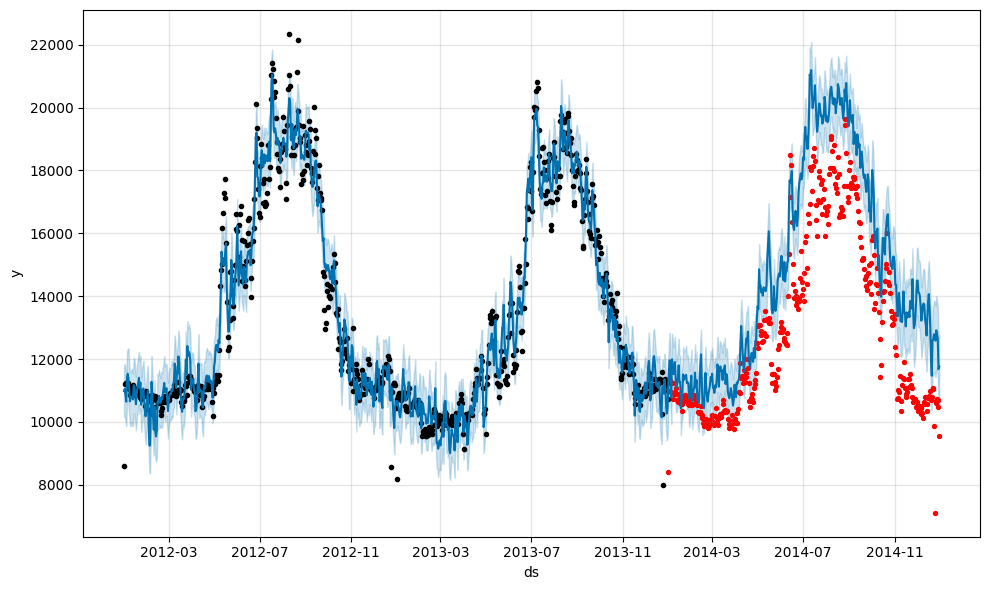

In [23]:
fig = fb_prophet.plot(forecast)
plt.scatter(cluster_0_test['ds'], cluster_0_test['y'], s=8, c='r')

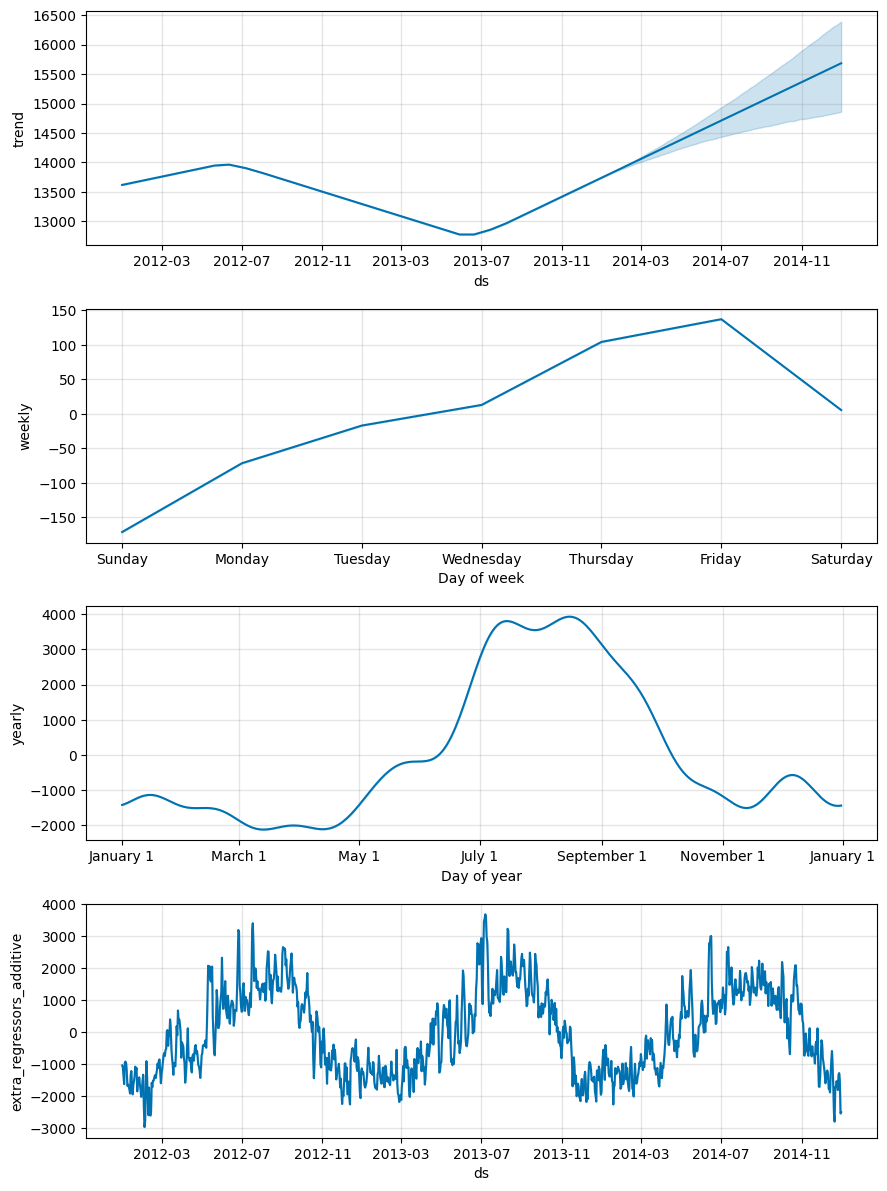

In [24]:
fb_prophet.plot_components(forecast);

### Cluster 1

In [25]:
# Reset index, ename columns
cluster_1_norm_final = cluster_1_norm.reset_index().rename(columns={"date": "ds", "cluster_1": "y"})
cluster_1_norm_final['ds'] = pd.to_datetime(cluster_1_norm_final['ds'])

In [26]:
cluster_1_norm_merged = cluster_1_norm_final.merge(temp, left_on='ds', right_on='date').merge(precip, left_on='ds', right_on='date')

In [27]:
cluster_1_train = cluster_1_norm_merged.iloc[0:731,:]
cluster_1_test = cluster_1_norm_merged.iloc[731:,:]

In [28]:
fb_prophet = Prophet()
fb_prophet.add_regressor('tmin')
fb_prophet.add_regressor('tmax')
fb_prophet.add_regressor('precip')
fb_prophet.fit(cluster_1_train)

18:36:08 - cmdstanpy - INFO - Chain [1] start processing
18:36:09 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
forecast = fb_prophet.predict(cluster_1_norm_merged)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-01,19352.797482,17509.032777,19176.003851,19352.797482,19352.797482,-972.427679,-972.427679,-972.427679,-522.197486,...,248.273069,248.273069,248.273069,-698.503262,-698.503262,-698.503262,0.0,0.0,0.0,18380.369803
1,2011-01-02,19355.798378,16579.812736,18204.360394,19355.798378,19355.798378,-1970.931118,-1970.931118,-1970.931118,-872.933405,...,-408.583604,-408.583604,-408.583604,-689.414109,-689.414109,-689.414109,0.0,0.0,0.0,17384.867260
2,2011-01-03,19358.799274,16373.111604,18032.426361,19358.799274,19358.799274,-2146.133063,-2146.133063,-2146.133063,-1385.573167,...,-87.823838,-87.823838,-87.823838,-672.736058,-672.736058,-672.736058,0.0,0.0,0.0,17212.666211
3,2011-01-04,19361.800170,16642.833543,18362.796595,19361.800170,19361.800170,-1901.767292,-1901.767292,-1901.767292,-1297.708483,...,44.674271,44.674271,44.674271,-648.733080,-648.733080,-648.733080,0.0,0.0,0.0,17460.032878
4,2011-01-05,19364.801066,17054.309028,18702.333591,19364.801066,19364.801066,-1496.749112,-1496.749112,-1496.749112,-838.173154,...,-40.761018,-40.761018,-40.761018,-617.814940,-617.814940,-617.814940,0.0,0.0,0.0,17868.051953


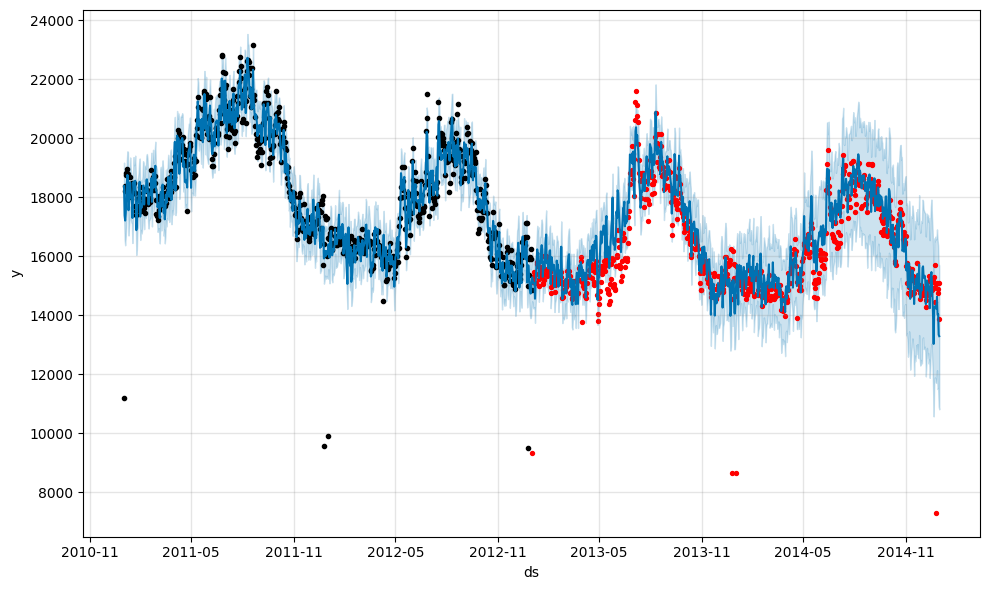

In [30]:
fig = fb_prophet.plot(forecast)
plt.scatter(cluster_1_test['ds'], cluster_1_test['y'], s=8, c='r')

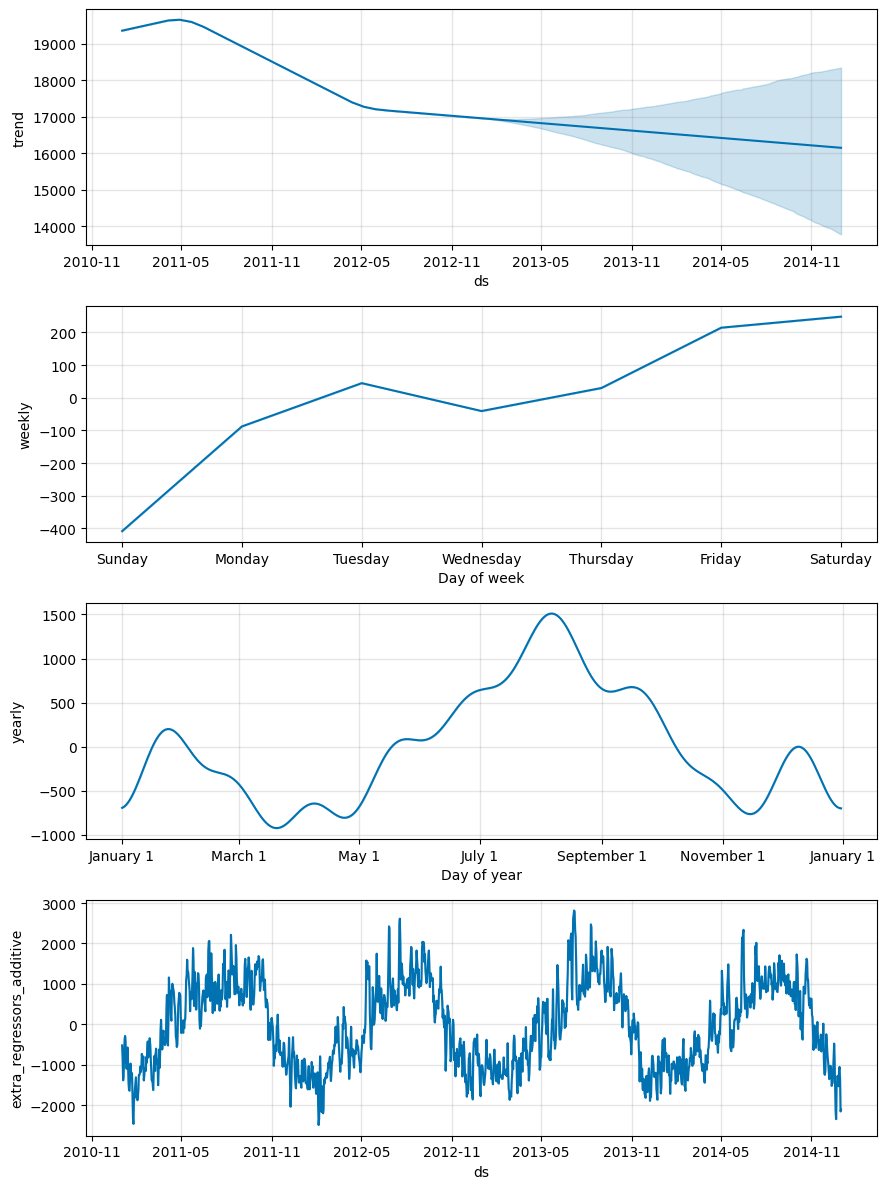

In [31]:
fb_prophet.plot_components(forecast);